In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from pandarallel import pandarallel
from matplotlib.colors import to_hex
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import accuracy_score
from reval.utils import kuhn_munkres_algorithm
from tqdm.contrib.itertools import product
import networkx as nx
from tqdm.notebook import tqdm

from src.utils import GetMetrics
from settings import RANDOM_STATE, COMPLETE_METRICS_PATH, COMPLETE_RESULTS_PATH, INCOMPLETE_METRICS_PATH, INCOMPLETE_RESULTS_PATH, \
    COMPLETE_INMETRICS_PATH, INCOMPLETE_INMETRICS_PATH, COMPARISON_ALG_PATH, UNS_METRICS_ALG_PATH

In [2]:
folder_results = "results"
indexes = ["dataset", "algorithm", "missing_percentage", "amputation_mechanism", "imputation", "run_n"]
n_permutations = 10
nb_workers = 5

In [3]:
outputs = GetMetrics.save_cluster_evaluation(INCOMPLETE_RESULTS_PATH, INCOMPLETE_METRICS_PATH, INCOMPLETE_INMETRICS_PATH, random_state = RANDOM_STATE,
                                             n_permutations=n_permutations, verbose= True, nb_workers=nb_workers)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
results (292000, 30)
finished_results (63400, 30)
completed_results (40788, 30)


metrics_results (40788, 42)
aggregated_results (898, 55)


In [4]:
outputs = GetMetrics.save_cluster_evaluation(COMPLETE_RESULTS_PATH, COMPLETE_METRICS_PATH, COMPLETE_INMETRICS_PATH, random_state = RANDOM_STATE,
                                             n_permutations=n_permutations, verbose= True, nb_workers=nb_workers)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
results (402850, 30)
finished_results (74600, 30)
completed_results (70458, 30)


/home/alberto/PycharmProjects/incomplete_multiview_clustering/src/utils/get_metrics.py:78: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(results_path)


/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  

metrics_results (70458, 42)
aggregated_results (1431, 55)


In [3]:
pandarallel.initialize(nb_workers=5, progress_bar=True)
results = pd.read_csv(COMPLETE_RESULTS_PATH)
results = results[results["finished"]]
results = results[results["completed"]]
results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]] = results[
    ["y_true", "y_pred", "y_true_idx", "y_pred_idx"]].parallel_applymap(eval)
assert results["y_true_idx"].eq(results["y_pred_idx"]).all()

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_108426/280775997.py:2: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(COMPLETE_RESULTS_PATH)


In [7]:
comparison_columns= ["dataset", "alg1", "alg2", "run_n", "pred_alg1", "pred_alg2", "y_true"]
alg_comparisons = pd.DataFrame([], columns= comparison_columns)

for dataset,run_n,(alg1,alg2) in product(results["dataset"].unique(), sorted(results["run_n"].unique()), set(itertools.combinations(results["algorithm"].unique(), 2))):
    pred_alg1 = results.loc[(results["dataset"] == dataset) &
                            (results["missing_percentage"] == 0) &
                            (results["run_n"] == run_n) &
                            (results["algorithm"] == alg1),
                            ["y_pred", "y_true", "y_pred_idx"]]
    pred_alg2 = results.loc[(results["dataset"] == dataset) &
                            (results["missing_percentage"] == 0) &
                            (results["run_n"] == run_n) &
                            (results["algorithm"] == alg2),
                            ["y_pred", "y_true", "y_pred_idx"]]
    if pred_alg1.empty or pred_alg2.empty:
        continue
    y1 = np.array(pred_alg1["y_true"].values[0])
    y2 = np.array(pred_alg2["y_true"].values[0])
    assert (y1 == y2).all()
    alg_comparison = pd.DataFrame([[dataset, alg1, alg2, run_n, 
                                    pred_alg1["y_pred"].values[0], pred_alg2["y_pred"].values[0], y1]],
                                  columns= comparison_columns)
    alg_comparisons = pd.concat([alg_comparisons, alg_comparison], ignore_index=True)
alg_comparisons

  0%|          | 0/5250 [00:00<?, ?it/s]

,dataset,alg1,alg2,run_n,pred_alg1,pred_alg2,y_true
0,simulated_gm,MVCoRegSpectralClustering,SNF,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
1,simulated_gm,Concat,GroupPCA,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
2,simulated_gm,NMFC,MVCoRegSpectralClustering,0,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
3,simulated_gm,NMFC,SNF,0,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
4,simulated_gm,MVSpectralClustering,MVCoRegSpectralClustering,0,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...
4945,sensIT300,NMFC,GroupPCA,49,"[0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, ...","[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, ..."
4946,sensIT300,GroupPCA,SNF,49,"[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, ...","[0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, ..."
4947,sensIT300,SNF,AJIVE,49,"[0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, ...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","[0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, ..."
4948,sensIT300,Concat,MVSpectralClustering,49,"[1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, ...","[1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, ...","[0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, ..."


In [8]:
alg_comparisons["AMI"] = alg_comparisons.apply(lambda x: adjusted_mutual_info_score(x["pred_alg1"], x["pred_alg2"]), axis= 1)
alg_comparisons["Overlapping"] = alg_comparisons.apply(lambda x: accuracy_score(x["pred_alg1"], kuhn_munkres_algorithm(true_lab=x["pred_alg1"], pred_lab=x["pred_alg2"])), axis= 1)
alg_comparisons = alg_comparisons.groupby(["alg1", "alg2"], as_index=False)[["AMI", "Overlapping"]].mean().sort_values("AMI", ascending=False)
alg_comparisons["Comparison"] = alg_comparisons["alg1"] + "_" + alg_comparisons["alg2"]
alg_comparisons.to_csv(os.path.join(COMPARISON_ALG_PATH), index=None)

NameError: name 'RES' is not defined

In [ ]:
_ = alg_comparisons.plot(kind="bar", x="Comparison")

In [150]:
def plot_graph(df, alg1_col, alg2_col, value_col, figsize= (12, 8), random_state = None):
    G = nx.Graph()
    df.apply(lambda x: G.add_edge(x[alg1_col], x[alg2_col], weight=round(x[value_col], 2)), axis= 1)
    for index, row in alg_comparisons.iterrows():
        G.add_edge(row[alg1_col], row[alg2_col], weight=round(row[value_col], 2))
    pos = nx.spring_layout(G, seed=random_state)  # positions for all nodes
    plt.figure(figsize=(12, 8))  # Change the figure size
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    edges = nx.draw_networkx_edges(
        G, pos, edgelist=edges, width=[w * 10 for w in weights],
        edge_color=weights, edge_cmap=plt.cm.Blues, edge_vmin=min(weights), edge_vmax=max(weights)
    )
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    plt.colorbar(sm, label=f"Agreement ({value_col})", ax=plt.gca())
    plt.show()

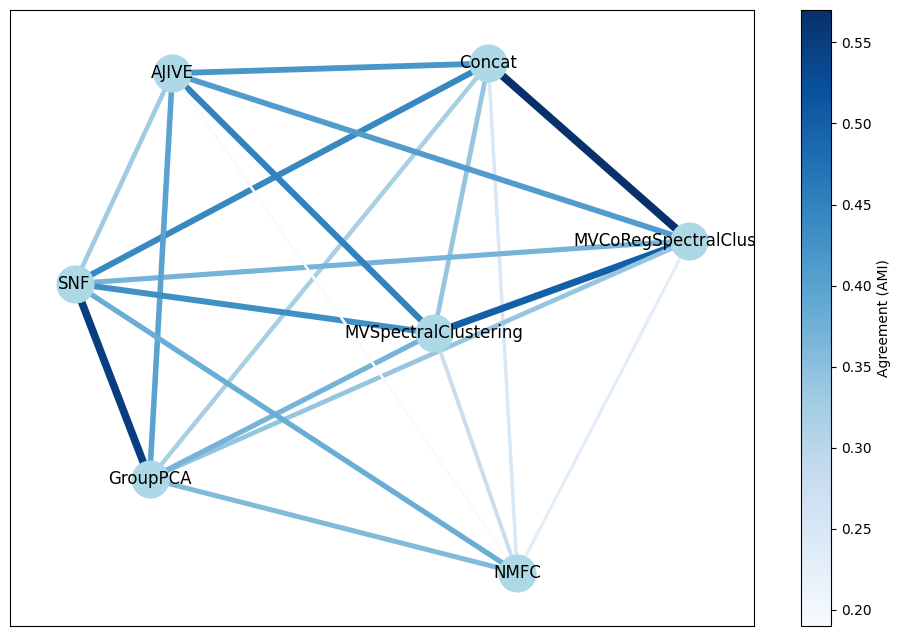

In [151]:
plot_graph(df= alg_comparisons, alg1_col="alg1", alg2_col="alg2", value_col="AMI", random_state=RANDOM_STATE)

In [12]:
alg_stability = results.loc[results["missing_percentage"] == 0, ['dataset', 'algorithm', 'missing_percentage', 'amputation_mechanism', 'imputation', 'run_n',
                                                                 "y_pred", "y_pred_idx",
                                                                 'silhouette', 'vrc', 'db', 'dbcv', 'dunn']]
alg_stability["sorted_preds"] = alg_stability.apply(lambda x: pd.Series(x["y_pred"], index= x["y_pred_idx"]).sort_index().to_list(), axis= 1)


In [14]:
alg_stability[["y_pred", "y_pred_idx", "sorted_preds"]]

,y_pred,y_pred_idx,sorted_preds
0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
1,"[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
2,"[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
3,"[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
4,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, ...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...","[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
...,...,...,...
1745,"[2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, ...","[225, 140, 13, 165, 199, 96, 294, 221, 105, 18...","[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1746,"[1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[82, 131, 138, 52, 22, 5, 219, 9, 278, 230, 18...","[1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, ..."
1747,"[2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, ...","[85, 66, 95, 256, 119, 159, 170, 26, 293, 253,...","[1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, ..."
1748,"[0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, ...","[83, 170, 137, 164, 242, 162, 288, 181, 241, 1...","[2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, ..."


In [ ]:
alg_stability = results[['dataset', 'algorithm', 'missing_percentage', 'amputation_mechanism', 'imputation', 'run_n',
                         "y_pred", "y_pred_idx", 'silhouette', 'vrc', 'db', 'dbcv', 'dunn']]
alg_stability = alg_stability.loc[alg_stability["imputation"]]
alg_uns_metrics = alg_stability.drop(columns= ["y_pred", "y_pred_idx", 'amputation_mechanism', 'imputation', 'run_n'])
alg_uns_metrics = alg_uns_metrics.groupby(["dataset", "algorithm", "missing_percentage"], as_index= False).mean()
alg_stability["sorted_preds"] = alg_stability.apply(lambda x: pd.Series(x["y_pred"], index= x["y_pred_idx"]).sort_index().to_list(), axis= 1)

for dataset in tqdm(alg_stability["dataset"].unique()):
    preds_dataset = alg_stability.loc[(alg_stability["dataset"] == dataset), ["missing_percentage", "algorithm", "run_n", "sorted_preds"]]
    for alg in preds_dataset["algorithm"].unique():
        pred_alg = preds_dataset[preds_dataset["algorithm"] == alg]
        for missing_percentage in pred_alg["missing_percentage"].unique():
            pred_missing_alg = pred_alg[pred_alg["missing_percentage"] == missing_percentage]
            amis,aris = [], []
            for run_1,run_2 in set(itertools.combinations(pred_missing_alg["run_n"].unique(), 2)):
                pred1_alg = pred_missing_alg.loc[(pred_missing_alg["run_n"] == run_1), "sorted_preds"].to_list()[0]
                pred2_alg = pred_missing_alg.loc[(pred_missing_alg["run_n"] == run_2), "sorted_preds"].to_list()[0]
                amis.append(adjusted_mutual_info_score(pred1_alg, pred2_alg)), aris.append(adjusted_rand_score(pred1_alg, pred2_alg))

            alg_uns_metrics.loc[(alg_uns_metrics["dataset"] == dataset) &
                                (alg_uns_metrics["missing_percentage"] == missing_percentage) &
                                (alg_uns_metrics["algorithm"] == alg), ["AMI", "ARI"]] = [np.mean(amis), np.mean(aris)]
    
alg_uns_metrics = alg_uns_metrics.groupby(["missing_percentage", "algorithm"], as_index= False).mean(numeric_only=True)
alg_uns_metrics.to_csv(os.path.join(UNS_METRICS_ALG_PATH), index=None)
alg_uns_metrics

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
stability_supervised_metrics = results[(results["imputation"]) | (results["missing_percentage"] == 0)].parallel_apply(
    lambda x: [GetMetrics.compute_supervised_metrics(y_true= pred, y_pred= pd.Series(x["y_pred"], index= x["y_pred_idx"]).sort_index().values,
                                                     random_state = RANDOM_STATE, n_permutations=2) for pred in x["y_pred_wo_missing"]], axis= 1)
results.loc[stability_supervised_metrics.index, "stability_supervised_metrics"] = stability_supervised_metrics.parallel_apply(
    lambda x:{f"{key}_{i}": value for i,run_n in enumerate(x) for key,value in run_n.items()})
stability_supervised_metrics = pd.DataFrame(results.loc[stability_supervised_metrics.index, "stability_supervised_metrics"].to_dict(), columns=stability_supervised_metrics.index).T
results = pd.concat([results, stability_supervised_metrics], axis=1)

/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  

In [6]:
stability_supervised_metrics = results[(results["dataset"] == dataset) & ((results["imputation"]) | (results["missing_percentage"] == 0))].iloc[:1000].parallel_apply(
    lambda x: [GetMetrics.compute_supervised_metrics(y_true= pred, y_pred= pd.Series(x["y_pred"], index= x["y_pred_idx"]).sort_index().values,
                                                     random_state = RANDOM_STATE, n_permutations=2) for pred in x["y_pred_wo_missing"]], axis= 1)

In [30]:
results.loc[stability_supervised_metrics.index, "stability_supervised_metrics"] = stability_supervised_metrics.parallel_apply(
    lambda x:{f"{key}_{i}": value for i,run_n in enumerate(x) for key,value in run_n.items()})

In [38]:
stability_supervised_metrics = pd.DataFrame(results.loc[stability_supervised_metrics.index, "stability_supervised_metrics"].to_dict(), columns=stability_supervised_metrics.index).T
results = pd.concat([results, stability_supervised_metrics], axis=1)

In [39]:
results

,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,MCC (p-value)_49,F1_49,precision_49,recall_49,bal_acc_49,ami_49,ari_49,completeness_49,random_acc_49,random_f1_49
0,simulated_gm,Concat,0,No,False,0,True,True,True,100.0,...,0.333333,1.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,0.55,0.354839
1,simulated_gm,Concat,0,No,False,1,True,True,True,100.0,...,0.333333,1.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,0.55,0.354839
2,simulated_gm,Concat,0,No,False,2,True,True,True,100.0,...,0.333333,1.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,0.55,0.354839
3,simulated_gm,Concat,0,No,False,3,True,True,True,100.0,...,0.333333,0.989878,0.991071,0.988889,0.011111,0.928061,0.96,0.930088,0.55,0.354839
4,simulated_gm,Concat,0,No,False,4,True,True,True,100.0,...,0.333333,0.989878,0.991071,0.988889,0.988889,0.928061,0.96,0.930088,0.55,0.354839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367095,buaa,SNF,90,PM,True,45,True,True,True,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367096,buaa,SNF,90,PM,True,46,True,True,True,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367097,buaa,SNF,90,PM,True,47,True,True,True,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367098,buaa,SNF,90,PM,True,48,True,True,True,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
x

dataset                                                       nutrimouse_genotype
algorithm                                                                     SNF
missing_percentage                                                             90
amputation_mechanism                                                           PM
imputation                                                                  False
run_n                                                                          49
finished                                                                     True
completed                                                                    True
time_limited                                                                 True
n_samples                                                                     4.0
n_views                                                                       2.0
n_incomplete_samples                                                          0.0
n_complete_sampl

In [ ]:
results[(~results["stability_supervised_metrics"].isna()) & (results["dataset"] == "simulated_gm")]["missing_percentage"].unique()

In [76]:
results.loc[(results["dataset"] == dataset) &
            (results["algorithm"] == alg) &
            (results["missing_percentage"] == missing_percentage) &
            (results["amputation_mechanism"] == amputation_mechanism)].parallel_apply(
    lambda x: [GetMetrics.compute_supervised_metrics(y_true= pred, y_pred= pd.Series(x["y_pred"], index= x["y_pred_idx"]).sort_index().values,
                                                     random_state = RANDOM_STATE, n_permutations=10) for pred in x["y_pred_wo_missing"]], axis= 1)

ValueError: Number of processes must be at least 1

In [72]:
results["stability_supervised_metrics"].parallel_apply(lambda x:{f"{key}_stab": value for key,value in x.items()})

AttributeError: 'float' object has no attribute 'items'

In [23]:
results = pd.read_csv(COMPLETE_RESULTS_PATH)
results = results[results["finished"]]
results = results[results["completed"]]
results.loc[(results["dataset"] == dataset) & (results["missing_percentage"] == 0), ["y_pred", "y_pred_idx"]]

/tmp/ipykernel_57513/1934383422.py:1: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(COMPLETE_RESULTS_PATH)


,y_pred,y_pred_idx
350,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[19, 16, 15, 26, 4, 12, 37, 27, 39, 6, 25, 9, ..."
351,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, ...","[19, 13, 24, 31, 7, 6, 35, 9, 20, 37, 10, 32, ..."
352,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...","[36, 5, 11, 38, 19, 15, 27, 17, 31, 26, 16, 12..."
353,"[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[5, 13, 7, 0, 37, 20, 9, 19, 35, 39, 18, 16, 1..."
354,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ...","[3, 38, 6, 4, 17, 10, 9, 39, 7, 30, 26, 13, 14..."
...,...,...
695,"[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","[24, 37, 5, 20, 0, 1, 35, 2, 7, 16, 17, 30, 4,..."
696,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[39, 37, 2, 31, 19, 17, 21, 9, 29, 34, 36, 0, ..."
697,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...","[25, 3, 11, 9, 15, 37, 16, 12, 21, 14, 10, 34,..."
698,"[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, ...","[39, 36, 7, 26, 14, 17, 20, 5, 21, 22, 2, 1, 1..."


In [22]:
results.loc[(results["dataset"] == dataset) & (results["missing_percentage"] == 0), ["y_pred", "y_pred_idx"]]

,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
350,nutrimouse_genotype,Concat,0,No,False,0,True,True,True,40.0,...,"{1: 0.65, 0: 0.35}","[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[19, 16, 15, 26, 4, 12, 37, 27, 39, 6, 25, 9, ...","[19, 16, 15, 26, 4, 12, 37, 27, 39, 6, 25, 9, ...",0.193285,12.253764,1.659324,-0.273467,0.423898
351,nutrimouse_genotype,Concat,0,No,False,1,True,True,True,40.0,...,"{1: 0.625, 0: 0.375}","[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, ...","[19, 13, 24, 31, 7, 6, 35, 9, 20, 37, 10, 32, ...","[19, 13, 24, 31, 7, 6, 35, 9, 20, 37, 10, 32, ...",0.193901,12.451346,1.678584,-0.271872,0.425559
352,nutrimouse_genotype,Concat,0,No,False,2,True,True,True,40.0,...,"{1: 0.6, 0: 0.4}","[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...","[36, 5, 11, 38, 19, 15, 27, 17, 31, 26, 16, 12...","[36, 5, 11, 38, 19, 15, 27, 17, 31, 26, 16, 12...",0.189743,12.439817,1.698891,-0.270283,0.425559
353,nutrimouse_genotype,Concat,0,No,False,3,True,True,True,40.0,...,"{1: 0.6, 0: 0.4}","[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...","[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[5, 13, 7, 0, 37, 20, 9, 19, 35, 39, 18, 16, 1...","[5, 13, 7, 0, 37, 20, 9, 19, 35, 39, 18, 16, 1...",0.189743,12.439817,1.698891,-0.270283,0.425559
354,nutrimouse_genotype,Concat,0,No,False,4,True,True,True,40.0,...,"{1: 0.6, 0: 0.4}","[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ...","[3, 38, 6, 4, 17, 10, 9, 39, 7, 30, 26, 13, 14...","[3, 38, 6, 4, 17, 10, 9, 39, 7, 30, 26, 13, 14...",0.189743,12.439817,1.698891,-0.270283,0.425559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,nutrimouse_genotype,SNF,0,No,False,45,True,True,True,40.0,...,"{0: 0.5, 1: 0.5}","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","[24, 37, 5, 20, 0, 1, 35, 2, 7, 16, 17, 30, 4,...","[24, 37, 5, 20, 0, 1, 35, 2, 7, 16, 17, 30, 4,...",0.093514,5.266628,2.683590,0.054432,0.931412
696,nutrimouse_genotype,SNF,0,No,False,46,True,True,True,40.0,...,"{1: 0.5, 0: 0.5}","[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[39, 37, 2, 31, 19, 17, 21, 9, 29, 34, 36, 0, ...","[39, 37, 2, 31, 19, 17, 21, 9, 29, 34, 36, 0, ...",0.093514,5.266628,2.683590,0.054432,0.931412
697,nutrimouse_genotype,SNF,0,No,False,47,True,True,True,40.0,...,"{0: 0.5, 1: 0.5}","[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...","[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...","[25, 3, 11, 9, 15, 37, 16, 12, 21, 14, 10, 34,...","[25, 3, 11, 9, 15, 37, 16, 12, 21, 14, 10, 34,...",0.093514,5.266628,2.683590,0.054432,0.931412
698,nutrimouse_genotype,SNF,0,No,False,48,True,True,True,40.0,...,"{0: 0.5, 1: 0.5}","[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, ...","[39, 36, 7, 26, 14, 17, 20, 5, 21, 22, 2, 1, 1...","[39, 36, 7, 26, 14, 17, 20, 5, 21, 22, 2, 1, 1...",0.093514,5.266628,2.683590,0.054432,0.931412


In [29]:
pandarallel.initialize(nb_workers=5)
results = pd.read_csv(COMPLETE_RESULTS_PATH)
results = results[results["finished"]]
results = results[results["completed"]]
results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]] = results[
    ["y_true", "y_pred", "y_true_idx", "y_pred_idx"]].parallel_applymap(eval)
assert results["y_true_idx"].eq(results["y_pred_idx"]).all()


INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_57513/3357697400.py:2: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(COMPLETE_RESULTS_PATH)


In [30]:
dataset = "nutrimouse_genotype"
preds = results.loc[(results["dataset"] == dataset) & (results["algorithm"] == alg) & (results["missing_percentage"] == 0), ["y_pred", "y_pred_idx"]]
results["y_pred_wo_missing"] = preds.apply(lambda x: pd.Series(x["y_pred"], index= x["y_pred_idx"]).to_list(), axis= 1).to_list()
# results.loc[(results["dataset"] == dataset) & (results["missing_percentage"] == 0), ["y_pred", "y_pred_idx"]].apply(lambda x: pd.Series(x["y_pred"], index= x["y_pred_idx"]).to_list()).to_list()

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1],
 [1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1],
 [0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1],
 [1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
 

## Incomplete

In [4]:
results = pd.read_csv(INCOMPLETE_RESULTS_PATH)
print("results", results.shape)
results.head()

results (292000, 30)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
0,simulated_gm,DAIMC,0,No,False,0,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,simulated_gm,DAIMC,0,No,False,1,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,simulated_gm,DAIMC,0,No,False,2,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,simulated_gm,DAIMC,0,No,False,3,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,simulated_gm,DAIMC,0,No,False,4,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
results = results[results["finished"]]
print("results", results.shape)

results (63400, 30)


In [6]:
errors = results[~results["completed"]]["comments"].parallel_map(lambda x: list(eval(x).keys())[0].split(": ")[0])

In [7]:
errors.value_counts()

comments
Oct2PyError          21919
BlockingIOError        316
ValueError             130
KeyError               114
TypeError              100
OSError                 21
MatReadError             7
FileNotFoundError        3
RuntimeError             2
Name: count, dtype: int64

In [8]:
results = results[results["completed"]]
print("results", results.shape)

results (40788, 30)


In [9]:
results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]] = results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]].parallel_applymap(eval)
assert results["y_true_idx"].eq(results["y_pred_idx"]).all()

In [10]:
results = results[results["missing_percentage"] == 0]
# results = results.iloc[:100]
results.head()

,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
200,simulated_gm,MSNE,0,No,False,0,True,True,True,100.0,...,"{0: 0.71, 1: 0.29}","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...","[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...",0.017832,1.791048,5.939833,-0.845924,0.009375
201,simulated_gm,MSNE,0,No,False,1,True,True,True,100.0,...,"{1: 0.72, 0: 0.28}","[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...",-0.001305,0.090959,26.848504,-0.885594,0.007385
202,simulated_gm,MSNE,0,No,False,2,True,True,True,100.0,...,"{0: 0.59, 1: 0.41}","[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...",-0.006650,0.365098,14.509747,-0.861617,0.007385
203,simulated_gm,MSNE,0,No,False,3,True,True,True,100.0,...,"{0: 0.69, 1: 0.31}","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...",-0.037499,0.224213,16.786982,-0.860414,0.007195
204,simulated_gm,MSNE,0,No,False,4,True,True,True,100.0,...,"{1: 0.62, 0: 0.38}","[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...","[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...",0.005912,0.823181,9.564205,-0.885502,0.009375


In [11]:
supervised_metrics = results[["y_true", "y_pred"]].parallel_apply(
    lambda row: GetMetrics.compute_supervised_metrics(y_true=row["y_true"], y_pred=row["y_pred"], random_state= RANDOM_STATE), axis=1)

In [12]:
results = pd.concat([results, pd.DataFrame(supervised_metrics.to_dict()).T], axis= 1)
print("results", results.shape)
results.head()

results (2425, 42)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,MCC (p-value),F1,precision,recall,bal_acc,ami,ari,completeness,random_acc,random_f1
200,simulated_gm,MSNE,0,No,False,0,True,True,True,100.0,...,0.098,0.529239,0.560709,0.55,0.45,0.001548,0.001695,1.012034e-02,0.5,0.333333
201,simulated_gm,MSNE,0,No,False,1,True,True,True,100.0,...,0.065,0.537621,0.574405,0.56,0.56,0.006081,0.006306,1.514723e-02,0.5,0.333333
202,simulated_gm,MSNE,0,No,False,2,True,True,True,100.0,...,0.355,0.505999,0.510335,0.51,0.49,-0.007167,-0.009466,3.054008e-04,0.5,0.333333
203,simulated_gm,MSNE,0,No,False,3,True,True,True,100.0,...,0.181,0.512398,0.535063,0.53,0.47,-0.004590,-0.005086,3.402139e-03,0.5,0.333333
204,simulated_gm,MSNE,0,No,False,4,True,True,True,100.0,...,0.428,0.492695,0.500000,0.50,0.50,-0.007547,-0.009611,8.359306e-16,0.5,0.333333


In [13]:
indexes_names = ["dataset", "algorithm", "missing_percentage", "amputation_mechanism", "imputation"]
results = results[results.select_dtypes(include="float").columns.to_list() + indexes_names].groupby(indexes_names, sort= False).agg(["mean", 'std']).reset_index()
results.columns = results.columns.map('_'.join).str.strip('_')
results["size"] = results["MCC (p-value)_mean"].apply(lambda x: -np.log(x))
print("results", results.shape)
results.head()

results (53, 54)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,n_samples_mean,n_samples_std,n_views_mean,n_views_std,n_incomplete_samples_mean,...,ami_std,ari_mean,ari_std,completeness_mean,completeness_std,random_acc_mean,random_acc_std,random_f1_mean,random_f1_std,size
0,simulated_gm,MSNE,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.008768,-0.000180,0.011001,0.007530,0.008871,0.5,0.0,0.333333,0.0,1.635679
1,simulated_gm,OSLFIMVC,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.069263,0.199394,0.090488,0.157305,0.068807,0.5,0.0,0.333333,0.0,3.445961
2,simulated_gm,SIMCADC,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.077974,0.135928,0.078249,0.160561,0.083509,0.5,0.0,0.333333,0.0,3.557117
3,simulated_gm,PIMVC,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.060775,0.224645,0.075667,0.188530,0.061143,0.5,0.0,0.333333,0.0,3.628453
4,simulated_gm,MOFA,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.030760,0.247721,0.034669,0.208574,0.031743,0.5,0.0,0.333333,0.0,6.908755


In [14]:
results.to_csv(INCOMPLETE_METRICS_PATH, index= None)

In [15]:
results = pd.merge(results, pd.DataFrame(itertools.product(results["dataset"].unique(), results["algorithm"].unique()), columns = ["dataset", "algorithm"]), how= "right")
res = OneHotEncoder(sparse_output= False).set_output(transform= "pandas").fit_transform(results[["dataset", "algorithm"]])
for col in ["silhouette_mean", "silhouette_std", "MCC_mean", "MCC_std", "MCC (p-value)_mean", "MCC (p-value)_std"]:
    res[col] = results[col]
    results[col] = KNNImputer().set_output(transform= "pandas").fit_transform(X= res)[col]
    res = res.drop(columns=col)
results["size"] = results["MCC (p-value)_mean"].apply(lambda x: -np.log(x))
results.to_csv(INCOMPLETE_INMETRICS_PATH, index= None)

In [3]:
filelame = "incomplete_algorithms_evaluation.csv"
file_path = os.path.join(folder_results, filelame)
results = pd.read_csv(file_path)
print("results", results.shape)
results.head()

/tmp/ipykernel_123710/3990048263.py:3: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(file_path)


results (438000, 30)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
0,simulated_gm,DAIMC,0,No,False,0,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,simulated_gm,DAIMC,0,No,False,1,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,simulated_gm,DAIMC,0,No,False,2,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,simulated_gm,DAIMC,0,No,False,3,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,simulated_gm,DAIMC,0,No,False,4,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
results = results[results["finished"]]
print("results", results.shape)

results (41121, 30)


In [5]:
results = results[results["completed"]]
print("results", results.shape)

results (41121, 30)


In [6]:
results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]] = results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]].applymap(eval)
assert results["y_true_idx"].eq(results["y_pred_idx"]).all()
# results["y_true_final"] = results.apply(lambda x: pd.Series(eval(x["y_true"]), index= eval(x["y_true_idx"])).to_list(), axis= 1)
# results["y_pred_final"] = results.apply(lambda x: pd.Series(eval(x["y_pred"]), index= eval(x["y_pred_idx"])).to_list(), axis= 1)

In [34]:
a = results.apply(lambda x: pd.Series(eval(x["y_true"]), index= eval(x["y_true_idx"])), axis= 1)
a

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
103,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
results[["MCC_supervised", "MCC_supervised_pvalue"]] = results[["y_true", "y_pred"]].apply(lambda x: GetMetrics.compute_mcc(y_true= x["y_true"], y_pred= x["y_pred"]), axis= 1)

In [6]:
results = results[results["completed"]]
mask = results["dataset"].str.startswith("simulated")
results["dataset_type"] = mask.where(mask, "real").mask(mask, "synthetic")
results = results.rename(columns = {original_mcc_supervised: renamed_mcc_supervised, original_mcc_unsupervised: renamed_mcc_unsupervised})
print("results", results.shape)

In [7]:
nomissing_results = results.copy()
nomissing_results = nomissing_results[nomissing_results["missing_percentage"] == 0]
nomissing_results = nomissing_results.groupby(["dataset", "algorithm", "imputation", "dataset_type"], sort=False)[renamed_mcc_metrics]
nomissing_results = pd.concat([nomissing_results.mean(), nomissing_results.std()], axis= 1)
nomissing_results.columns = (nomissing_results.columns[:2] + "_avg").to_list() + (nomissing_results.columns[2:] + "_std").to_list()
nomissing_results = nomissing_results.reset_index()
color_dict = {alg:col for alg,col in zip(nomissing_results["algorithm"].unique(), list(sns.color_palette(None, nomissing_results["algorithm"].nunique()).as_hex()))}
nomissing_results.loc[:,"color"] = nomissing_results["algorithm"].apply(lambda x: color_dict[x])
print("nomissing_results", nomissing_results.shape)
nomissing_results.head()

In [8]:
px.scatter(nomissing_results, x="algorithm", y= renamed_avg_supervised, error_y= renamed_stability_supervised, template= "simple_white", facet_col= "dataset",
           facet_col_wrap=3, width=1400, height=1000, color= "algorithm", labels= labels_dict)

In [7]:
px.scatter(nomissing_results, x="algorithm", y= renamed_avg_supervised, error_y= renamed_stability_supervised, template= "simple_white", facet_col= "dataset",
           facet_col_wrap=3, width=1400, height=1000, color= "algorithm", labels= labels_dict)

In [8]:
nomissing_results["rank"] = 0
for d in nomissing_results["dataset"]:
    d_nomissing_results = nomissing_results[nomissing_results["dataset"] == d].sort_values([renamed_avg_supervised, renamed_stability_supervised], ascending= [False, True])
    nomissing_results.loc[d_nomissing_results.index, "rank"] = d_nomissing_results[renamed_avg_supervised].rank()
rank = nomissing_results.groupby(["algorithm", "imputation", "dataset_type"], sort=False)["rank"].mean().to_list()
by_datasettype_nomissing_results = results.copy()
by_datasettype_nomissing_results = by_datasettype_nomissing_results[by_datasettype_nomissing_results["missing_percentage"] == 0]
by_datasettype_nomissing_results = by_datasettype_nomissing_results.groupby(["algorithm", "imputation", "dataset_type"], sort=False)[renamed_mcc_metrics]
by_datasettype_nomissing_results = pd.concat([by_datasettype_nomissing_results.mean(), by_datasettype_nomissing_results.std()], axis= 1)
by_datasettype_nomissing_results.columns = (by_datasettype_nomissing_results.columns[:2] + "_avg").to_list() + (by_datasettype_nomissing_results.columns[2:] + "_std").to_list()
by_datasettype_nomissing_results = by_datasettype_nomissing_results.reset_index()
color_dict = {alg:col for alg,col in zip(by_datasettype_nomissing_results["algorithm"].unique(), list(sns.color_palette(None, by_datasettype_nomissing_results["algorithm"].nunique()).as_hex()))}
by_datasettype_nomissing_results.loc[:,"color"] = by_datasettype_nomissing_results["algorithm"].apply(lambda x: color_dict[x])
by_datasettype_nomissing_results["rank"] = rank
by_datasettype_nomissing_results["size"] = 1
print("by_datasettype_nomissing_results", by_datasettype_nomissing_results.shape)
by_datasettype_nomissing_results.head()

In [9]:
px.scatter(by_datasettype_nomissing_results, x="algorithm", y= renamed_avg_supervised, error_y= renamed_stability_supervised,
           template= "simple_white", facet_col = "dataset_type", size= "rank", color= "algorithm", labels= labels_dict)

In [10]:
px.scatter(by_datasettype_nomissing_results, x="rank", y= renamed_avg_supervised, error_y= renamed_stability_supervised, template= "simple_white", size= "size",
           facet_col = "dataset_type", text="algorithm", color= "algorithm", labels= labels_dict)

In [7]:
missing_results = results.copy()
missing_results = missing_results[missing_results["missing_percentage"] > 0]
missing_results = missing_results.groupby(["algorithm", "missing_percentage", "amputation_mechanism", "imputation", "dataset_type"], sort=False)[renamed_mcc_metrics]
missing_results = pd.concat([missing_results.mean(), missing_results.std()], axis= 1)
missing_results.columns = (missing_results.columns[:2] + "_avg").to_list() + (missing_results.columns[2:] + "_std").to_list()
missing_results = missing_results.reset_index()
color_dict = {alg:col for alg,col in zip(missing_results["algorithm"].unique(), list(sns.color_palette(None, missing_results["algorithm"].nunique()).as_hex()))}
missing_results.loc[:,"color"] = missing_results["algorithm"].apply(lambda x: color_dict[x])
# missing_results[renamed_stability_supervised] /= 5
# missing_results[renamed_stability_unsupervised] /= 2
missing_results["size"] = 1
print("missing_results", missing_results.shape)
missing_results.head()

In [12]:
fig = px.scatter(missing_results, x= renamed_avg_supervised, y= renamed_avg_unsupervised, animation_frame="missing_percentage", animation_group="algorithm",
                 size= "size", text="algorithm", color= "imputation", error_x=  renamed_stability_supervised,
                 error_y= renamed_stability_unsupervised, facet_row = "amputation_mechanism", facet_col = "dataset_type",
                 range_x=[0,1], range_y=[0,1], width=1400, height=2000, title= "Clustering performance on incomplete multi-view datasets",
                 template= "simple_white", labels= labels_dict)
fig

In [13]:
fig.write_html("test.html")

In [14]:
px.scatter(missing_results[missing_results["amputation_mechanism"] == "EDM"], x= renamed_avg_supervised, 
                 y= renamed_avg_unsupervised, animation_frame="missing_percentage", animation_group="algorithm",
                 size= "size", text="algorithm", color= "imputation", error_x=  renamed_stability_supervised,
                 error_y= renamed_stability_unsupervised, facet_row = "amputation_mechanism", facet_col = "dataset_type",
                 range_x=[0,1], range_y=[0,1], height=600, title= "Clustering performance on incomplete multi-view datasets",
                 template= "simple_white", labels= labels_dict)

In [15]:
missing_results = results.copy()
missing_results = missing_results[missing_results["missing_percentage"] > 0]
missing_results = missing_results.groupby(["algorithm", "missing_percentage", "amputation_mechanism", "imputation", "dataset_type"], sort=False)[supervised_metrics]
missing_results = pd.concat([missing_results.mean(), missing_results.std()], axis= 1)
missing_results.columns = (missing_results.columns[:2] + "_avg").to_list() + (missing_results.columns[2:] + "_std").to_list()
missing_results = missing_results.reset_index()
missing_results["rank"] = 0
for d in missing_results["dataset"]:
    d_missing_results = missing_results[missing_results["dataset"] == d].sort_values(["MCC_avg", "MCC_std"], ascending= [False, True])
    missing_results.loc[d_missing_results.index, "rank"] = d_missing_results["MCC_avg"].rank()


missing_results = results.copy()
missing_results = missing_results[missing_results["missing_percentage"] > 0]
missing_results = missing_results.groupby(["algorithm", "missing_percentage", "amputation_mechanism", "imputation", "dataset_type"], sort=False)[supervised_metrics]
missing_results = pd.concat([missing_results.mean(), missing_results.std()], axis= 1)
missing_results.columns = (missing_results.columns[:2] + "_avg").to_list() + (missing_results.columns[2:] + "_std").to_list()
missing_results = missing_results.reset_index()
color_dict = {alg:col for alg,col in zip(missing_results["algorithm"].unique(), list(sns.color_palette(None, missing_results["algorithm"].nunique()).as_hex()))}
missing_results.loc[:,"color"] = missing_results["algorithm"].apply(lambda x: color_dict[x])
missing_results["MCC_std"] = missing_results["MCC_std"]/10
missing_results["MCC_performance_std"] = missing_results["MCC_performance_std"]/5
print("missing_results", missing_results.shape)
missing_results.head()

## Complete

In [5]:
outputs = GetMetrics.save_cluster_evaluation(INCOMPLETE_RESULTS_PATH, INCOMPLETE_METRICS_PATH, INCOMPLETE_INMETRICS_PATH, random_state = RANDOM_STATE,
                                             n_permutations=10000, verbose= True)

results (292000, 30)
finished_results (63400, 30)
completed_results (40788, 30)


metrics_results (40788, 42)


AttributeError: module 'scipy.stats' has no attribute 'false_discovery_control'

In [11]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 10.3 MB/s eta 0:00:00


In [12]:
from statsmodels.stats.multitest import multipletests

In [14]:
multipletests([0.1, 0.3, 0.5, 0.0001])[1]

array([2.71000000e-01, 5.10000000e-01, 5.10000000e-01, 3.99940004e-04])

In [4]:
results = pd.read_csv(COMPLETE_RESULTS_PATH)
print("results", results.shape)
results.head()

results (402850, 30)


/tmp/ipykernel_95830/544326321.py:1: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(COMPLETE_RESULTS_PATH)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
0,simulated_gm,Concat,0,No,False,0,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...",0.338139,59.360658,1.129278,-0.740295,0.071581
1,simulated_gm,Concat,0,No,False,1,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...",0.338139,59.360658,1.129278,-0.740295,0.071581
2,simulated_gm,Concat,0,No,False,2,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...",0.338139,59.360658,1.129278,-0.799787,0.071581
3,simulated_gm,Concat,0,No,False,3,True,True,True,100.0,...,"{0: 0.56, 1: 0.44}","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...",0.338081,59.218763,1.123748,-0.743107,0.072350
4,simulated_gm,Concat,0,No,False,4,True,True,True,100.0,...,"{1: 0.56, 0: 0.44}","[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, ...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...",0.338081,59.218763,1.123748,-0.743107,0.072350


In [5]:
results = results[results["finished"]]
print("results", results.shape)

results (74600, 30)


In [6]:
errors = results[~results["completed"]]["comments"].parallel_map(lambda x: list(eval(x).keys())[0].split(": ")[0])

In [7]:
errors.value_counts()

comments
ValueError             3050
IndexError             1060
ArpackNoConvergence      32
Name: count, dtype: int64

In [8]:
results = results[results["completed"]]
print("results", results.shape)

results (70458, 30)


In [9]:
results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]] = results[["y_true", "y_pred", "y_true_idx", "y_pred_idx"]].parallel_applymap(eval)
assert results["y_true_idx"].eq(results["y_pred_idx"]).all()

In [23]:
results = results[results["missing_percentage"] == 0]
# results = results.iloc[:100]
results

,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,relative_cluster_sizes,y_true,y_pred,y_true_idx,y_pred_idx,silhouette,vrc,db,dbcv,dunn
0,simulated_gm,Concat,0,No,False,0,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...","[83, 53, 70, 45, 44, 39, 22, 80, 10, 0, 18, 30...",0.338139,59.360658,1.129278,-0.740295,0.071581
1,simulated_gm,Concat,0,No,False,1,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...","[20, 2, 15, 22, 57, 91, 69, 55, 11, 79, 9, 38,...",0.338139,59.360658,1.129278,-0.740295,0.071581
2,simulated_gm,Concat,0,No,False,2,True,True,True,100.0,...,"{0: 0.55, 1: 0.45}","[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...","[42, 54, 27, 93, 39, 65, 7, 26, 24, 60, 86, 30...",0.338139,59.360658,1.129278,-0.799787,0.071581
3,simulated_gm,Concat,0,No,False,3,True,True,True,100.0,...,"{0: 0.56, 1: 0.44}","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...","[0, 1, 62, 76, 37, 99, 78, 38, 2, 84, 60, 26, ...",0.338081,59.218763,1.123748,-0.743107,0.072350
4,simulated_gm,Concat,0,No,False,4,True,True,True,100.0,...,"{1: 0.56, 0: 0.44}","[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, ...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...","[71, 33, 37, 10, 44, 34, 24, 98, 73, 95, 50, 1...",0.338081,59.218763,1.123748,-0.743107,0.072350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,sensIT300,SNF,0,No,False,45,True,True,True,300.0,...,"{1: 0.43666666666666665, 0: 0.2933333333333333...","[2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 0, 0, ...","[2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, ...","[225, 140, 13, 165, 199, 96, 294, 221, 105, 18...","[225, 140, 13, 165, 199, 96, 294, 221, 105, 18...",-0.000551,1.186356,13.282134,-0.018503,0.936711
1746,sensIT300,SNF,0,No,False,46,True,True,True,300.0,...,"{1: 0.43666666666666665, 2: 0.2933333333333333...","[0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, ...","[1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ...","[82, 131, 138, 52, 22, 5, 219, 9, 278, 230, 18...","[82, 131, 138, 52, 22, 5, 219, 9, 278, 230, 18...",-0.000551,1.186356,13.282134,-0.026689,0.936711
1747,sensIT300,SNF,0,No,False,47,True,True,True,300.0,...,"{1: 0.43666666666666665, 2: 0.2933333333333333...","[0, 0, 0, 2, 1, 1, 1, 0, 2, 2, 0, 0, 2, 2, 0, ...","[2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, ...","[85, 66, 95, 256, 119, 159, 170, 26, 293, 253,...","[85, 66, 95, 256, 119, 159, 170, 26, 293, 253,...",-0.000551,1.186356,13.282134,-0.018704,0.936711
1748,sensIT300,SNF,0,No,False,48,True,True,True,300.0,...,"{2: 0.43666666666666665, 1: 0.2933333333333333...","[0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, ...","[0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, ...","[83, 170, 137, 164, 242, 162, 288, 181, 241, 1...","[83, 170, 137, 164, 242, 162, 288, 181, 241, 1...",-0.000551,1.186356,13.282134,-0.023281,0.936711


In [10]:
supervised_metrics = results[["y_true", "y_pred"]].parallel_apply(
    lambda row: GetMetrics.compute_supervised_metrics(y_true=row["y_true"], y_pred=row["y_pred"], random_state= RANDOM_STATE), axis=1)
supervised_metrics

/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  

0         {'ACC': 0.69, 'MCC': 0.3819143697985006, 'MCC ...
1         {'ACC': 0.69, 'MCC': 0.3819143697985006, 'MCC ...
2         {'ACC': 0.69, 'MCC': 0.3819143697985006, 'MCC ...
3         {'ACC': 0.68, 'MCC': 0.36262033381142117, 'MCC...
4         {'ACC': 0.68, 'MCC': 0.36262033381142117, 'MCC...
                                ...                        
367095    {'ACC': 0.8, 'MCC': 0.800966829217745, 'MCC (p...
367096    {'ACC': 0.9444444444444444, 'MCC': 0.940337716...
367097    {'ACC': 0.8777777777777778, 'MCC': 0.871642471...
367098    {'ACC': 0.9444444444444444, 'MCC': 0.940337716...
367099    {'ACC': 0.9444444444444444, 'MCC': 0.940337716...
Length: 70458, dtype: object

In [11]:
results = pd.concat([results, pd.DataFrame(supervised_metrics.to_dict()).T], axis= 1)
print("results", results.shape)
results.head()

results (70458, 42)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,run_n,finished,completed,time_limited,n_samples,...,MCC (p-value),F1,precision,recall,bal_acc,ami,ari,completeness,random_acc,random_f1
0,simulated_gm,Concat,0,No,False,0,True,True,True,100.0,...,0.000999,0.689223,0.691919,0.69,0.69,0.101848,0.135758,0.108846,0.5,0.333333
1,simulated_gm,Concat,0,No,False,1,True,True,True,100.0,...,0.000999,0.689223,0.691919,0.69,0.69,0.101848,0.135758,0.108846,0.5,0.333333
2,simulated_gm,Concat,0,No,False,2,True,True,True,100.0,...,0.000999,0.689223,0.691919,0.69,0.69,0.101848,0.135758,0.108846,0.5,0.333333
3,simulated_gm,Concat,0,No,False,3,True,True,True,100.0,...,0.000999,0.678844,0.682630,0.68,0.68,0.091008,0.120848,0.098216,0.5,0.333333
4,simulated_gm,Concat,0,No,False,4,True,True,True,100.0,...,0.000999,0.678844,0.682630,0.68,0.32,0.091008,0.120848,0.098216,0.5,0.333333


In [12]:
indexes_names = ["dataset", "algorithm", "missing_percentage", "amputation_mechanism", "imputation"]
results = results[results.select_dtypes(include="float").columns.to_list() + indexes_names].groupby(indexes_names, sort= False).agg(["mean", 'std']).reset_index()
results.columns = results.columns.map('_'.join).str.strip('_')
results["padj"] = false_discovery_control(results["MCC (p-value)_mean"])
results["log_padj"] = results["padj"].apply(lambda x: -np.log10(x))
print("results", results.shape)
results.head()

results (1431, 54)


,dataset,algorithm,missing_percentage,amputation_mechanism,imputation,n_samples_mean,n_samples_std,n_views_mean,n_views_std,n_incomplete_samples_mean,...,ami_std,ari_mean,ari_std,completeness_mean,completeness_std,random_acc_mean,random_acc_std,random_f1_mean,random_f1_std,size
0,simulated_gm,Concat,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.004536,0.132477,0.006239,0.106508,0.004448,0.5,0.0,0.333333,0.0,6.908755
1,simulated_gm,NMFC,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.000000,0.153102,0.000000,0.181119,0.000000,0.5,0.0,0.333333,0.0,6.908755
2,simulated_gm,MVSpectralClustering,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.000000,0.262967,0.000000,0.205626,0.000000,0.5,0.0,0.333333,0.0,6.908755
3,simulated_gm,MVCoRegSpectralClustering,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.000000,0.263003,0.000000,0.207649,0.000000,0.5,0.0,0.333333,0.0,6.908755
4,simulated_gm,GroupPCA,0,No,False,100.0,0.0,2.0,0.0,0.0,...,0.030349,0.239571,0.036104,0.199614,0.030802,0.5,0.0,0.333333,0.0,6.908755


In [13]:
results.to_csv(COMPLETE_METRICS_PATH, index= None)

In [14]:
results = pd.merge(results, pd.DataFrame(itertools.product(results["dataset"].unique(), results["algorithm"].unique()), columns = ["dataset", "algorithm"]), how= "right")
res = OneHotEncoder(sparse_output= False).set_output(transform= "pandas").fit_transform(results[["dataset", "algorithm"]])
for col in ["silhouette_mean", "silhouette_std", "MCC_mean", "MCC_std", "MCC (p-value)_mean", "MCC (p-value)_std"]:
    res[col] = results[col]
    results[col] = KNNImputer().set_output(transform= "pandas").fit_transform(X= res)[col]
    res = res.drop(columns=col)
results["padj"] = false_discovery_control(results["MCC (p-value)_mean"])
results["log_padj"] = results["padj"].apply(lambda x: -np.log10(x))
results.to_csv(COMPLETE_INMETRICS_PATH, index= None)

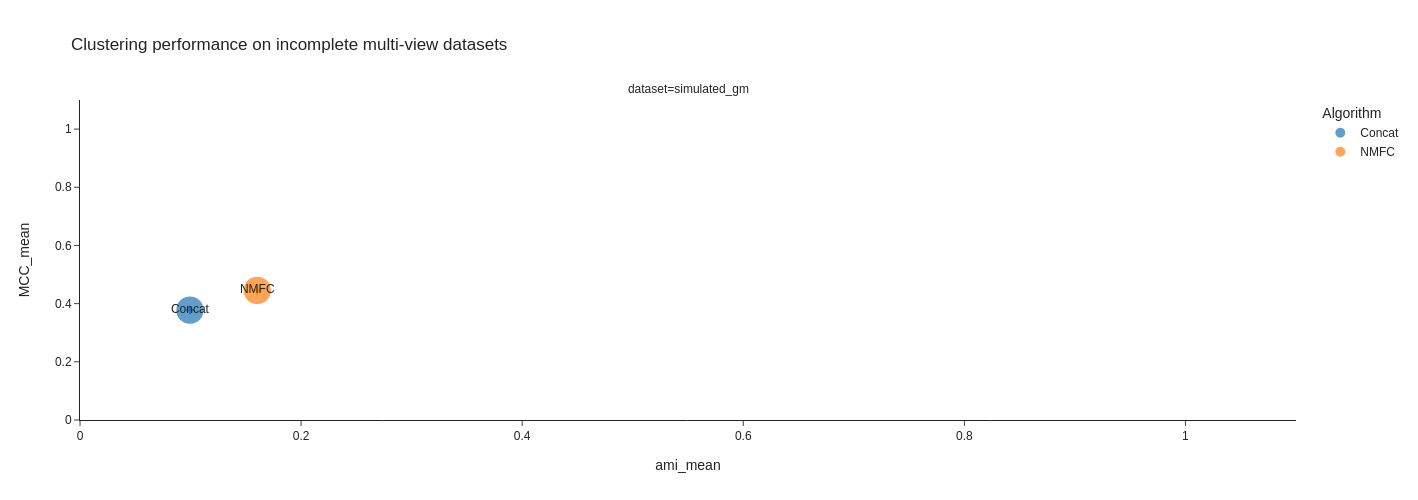

In [120]:
fig = px.scatter(results.reset_index(), x= "ami_mean", y= "MCC_mean", size= "size", text="algorithm", color= "algorithm", facet_col = "dataset", facet_col_wrap= 3,
                 range_x=[0,1.1], range_y=[0,1.1], width=1500, height=500, title= "Clustering performance on incomplete multi-view datasets",
                 template= "simple_white", labels= labels_dict, error_x="ami_var", error_y="MCC_var")
fig